# Rejection Sampling

We use rejection sampling to approximate a distribution, $f_{x|\theta}(x;\theta)$, that 1) we cannot directly sample from, or 2) would be difficult to sample from.  As an alternative, we are able to draw samples from another (often simpler) distribution, and then use these samples to approximate the distribution we're actually interested in.  In either case, where drawing samples from the target distribution is infeasible, we must, at the least, be able to compute the liklihood of samples from that target distribution.  That is, even if we cannot draw $x \sim f_{x|\theta}(x; \theta)$, we must still be able to compute $f_{x|\theta}(x)$, given that we have an $x \in \Omega_{x}$.

We can use rejection sampling to sample from some other distribution, $ y \sim g_{x|\phi}(x; \phi)$ (one that we know how to sample from).  For some scalar $M > 1$ such that $f_{x|\theta}(x) \leq M*g_{x|\phi}(x) \; \forall \; x$, we sample $y \sim g_{x|\phi}(x; \phi)$.  Then, we generate a sample $x \sim Unif(0,M*g_{x|\phi}(y))$.  We accept our initial sample $y$ if $y \leq f_{x|\theta}(x)$, and reject $y$ if $y > f_{x|\theta}(x)$.

In other words, we have a target distribution $f(x)$, which we cannot sample from for one reason or another, so we sample a random variable, $y$, from another distribution $g(x)$.  We then sample another random variable, $x$, from a Uniform distribution, where the end range of that Uniform distribution is defined by the probability of the $y$ we just sampled.  In this sense, $y$ defines the support of the Uniform distribution from which our $x$ is drawn.  Because we defined $M$ to be a scalar such that the density of each value in $M*g(x)$ is at least as big as the density of each value in $f(x)$, the support of this Uniform distribution spans a space, $[0,M*g(x)]$, at least as big as the range of $[0,f(x)]$ -- this means that, when we sample from the Uniform distribution, we might sample a value that is greater than $f(x)$

Thus, we see that, once we sample $x \sim Unif(0,M*g_{x|\phi}(y))$, the probability of accepting the value $y$ is proportional to: 

\begin{align}
\frac{f_{x|\theta}(x)}{M*g_{y|\phi}(y)}
\end{align}

This is easy to see if you look at the first plot showing the "Accept" and "Reject" delineations on the plot -- we simply divide the length of the green line, by the length of the red+green lines.

### Approxiating a Gamma Distribution using Samples from an Exponential Distribution

In this example, we define two distributions:  our sampling distribution $Exp(\lambda = 5)$, and our distribution that we wish to approximate $Gamma(\theta=7)$.

We sample 1000 points uniformly on 0.0001 to 0.9999 and plot the distribution of each.  Our sampling distribution has been scaled by $M = max\Big[\frac{Gamma(x;\theta)}{Exp(x;\lambda=5)}\Big]$.  This ensures that all scaled densities of the exponential are greater than the densities of the gamma, but more importantly, this means that we can guarantee that we will eventually sample the entire support of the distribution that we are trying to approximate.

Ideally, we choose the sampling distribution in order to minimize

\begin{align}
\int_{\Omega_{x}} M*g_{x|\phi}(x) dx - \int _{\Omega_{x}} f_{x|\theta}(x) dx
\end{align}

where again, we have found $M$ such that $f_{x|\theta}(x) \leq M*g_{x|\phi}(x) \; \forall \; x$, as this minimizes the number of samples that we have to generate in order to accurately approximate $f_{x|\theta}(x; \theta)$

In [35]:
import pandas as pd
from scipy import stats
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

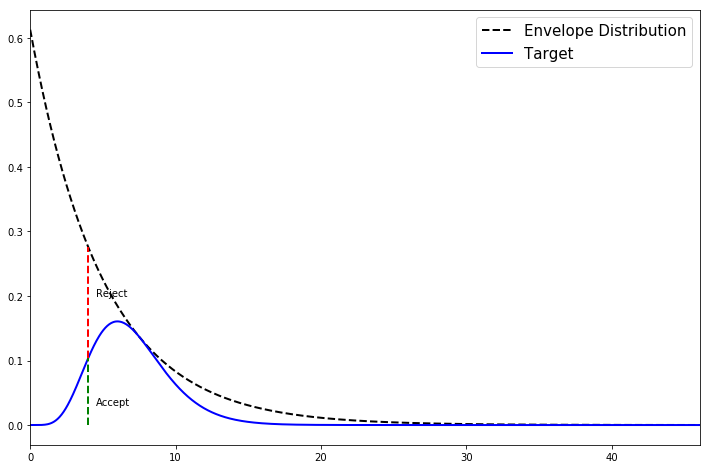

In [36]:
# define sampling and approximating distributions
E = stats.expon(scale=5)
G = stats.gamma(7)

x = np.linspace(min(G.ppf(0.0001),E.ppf(0.0001)),
                max(G.ppf(0.9999),E.ppf(0.9999)),1000)

# compute densities of both distributions
e_samples = E.pdf(x)
g_samples = G.pdf(x)

# compute scalar M
M = max(g_samples/e_samples)

df = pd.DataFrame({'Target': g_samples, 'Envelope Distribution': M * e_samples}, index=x)
ax = df.plot(style=['--', '-'], color=['black', 'blue'], 
             figsize=(12,8), linewidth=2.0);

ax.plot((4,4), (0, G.pdf(4)), 'g--', linewidth=2.0);
ax.plot((4,4), (G.pdf(4), M * E.pdf(4)), 'r--', linewidth=2.0);
ax.text(4.5, 0.20, 'Reject');
ax.text(4.5, 0.03, 'Accept');
ax.legend(fontsize=15);

We define a "rejection" method.  This method samples a random value $x \sim Exp(x;\lambda = 5)$, and scales its density by M.  We then sample a point $q \sim Unif(0,M*Exp_{x|\lambda = 5}(x))$.  If $q < Gamma(x; \theta=7)$, we keep $x$.  We run "rejection" 20000 times, to generate a set of "accepted" points.  We plot the normalized histogram of these points as well as the true gamma distribution to see how well we approximated the gamma distribution using this rejection sampling method.

In [37]:
def rejection(distr):
    while True:
        
        # sample a value from our sampling distribution
        x = distr.rvs()
        
        # scale its probability
        envelope = M*distr.pdf(x)
        
        # sample a uniform random variable from the range spanned by [0,x]
        q = np.random.uniform(0,envelope)
        
        # if this variable is less than the probability of our target distribution evaluated at x
        # keep x
        if q < G.pdf(x):
            return x

In [38]:
# generate list of accepted samples
samples = [rejection(E) for x in np.arange(20000)]

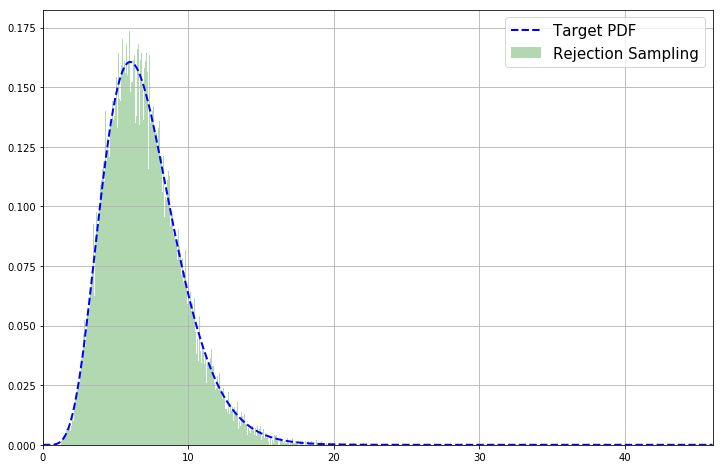

In [39]:
df['Target'].plot(color='blue', style='--', figsize=(12,8), linewidth=2.0)
pd.Series(samples).hist(bins=300, normed=True, color='green', 
                        alpha=0.3, linewidth=0.0)
plt.legend(['Target PDF', 'Rejection Sampling'],fontsize=15)

When we look at this plot, our first impression is that the rejection sampling works reasonably well.  However, upon examining it more closely, we can see that the samples appear to be much more dense near the mode of the Gamma distribution than towards the tails (the normalized bin probabilities are greater than the Gammma probability at the mode).  This is because of the shape of our sampling distribution in relation to the shape of the distribution that we are trying to approximate.  The probability of accepting a value is lower as we tend away from the mode -- this means that we need more samples to approximate the Gamma distribution periphery and tails more accurately than we do for its mode.  So, our $Exp(\lambda=5)$ distribution might not be the best envelope distribution for the $Gamma(\theta=7)$ distribution that we are trying to approximate.

Let's try approximating the $Gamma(\theta=7)$ with a normal distribution.

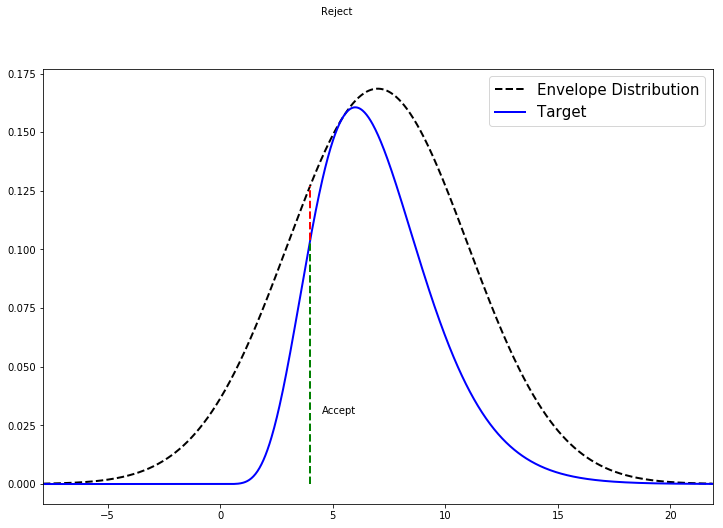

In [41]:
N = stats.norm(loc=7,scale=4)

x = np.linspace(min(G.ppf(0.0001),N.ppf(0.0001)),
                max(G.ppf(0.9999),N.ppf(0.9999)),1000)

# compute densities of both distributions
n_samples = N.pdf(x)
g_samples = G.pdf(x)

# compute scalar M
M = max(g_samples/n_samples)

df = pd.DataFrame({'Target': g_samples, 'Envelope Distribution': M*n_samples}, index=x)
ax = df.plot(style=['--', '-'], color=['black', 'blue'], 
             figsize=(12,8), linewidth=2.0);

ax.plot((4,4), (0, G.pdf(4)), 'g--', linewidth=2.0);
ax.plot((4,4), (G.pdf(4), M*N.pdf(4)), 'r--', linewidth=2.0);
ax.text(4.5, 0.20, 'Reject');
ax.text(4.5, 0.03, 'Accept');
ax.legend(fontsize=15);

In [42]:
# generate list of accepted samples
samples = [rejection(N) for x in np.arange(20000)]

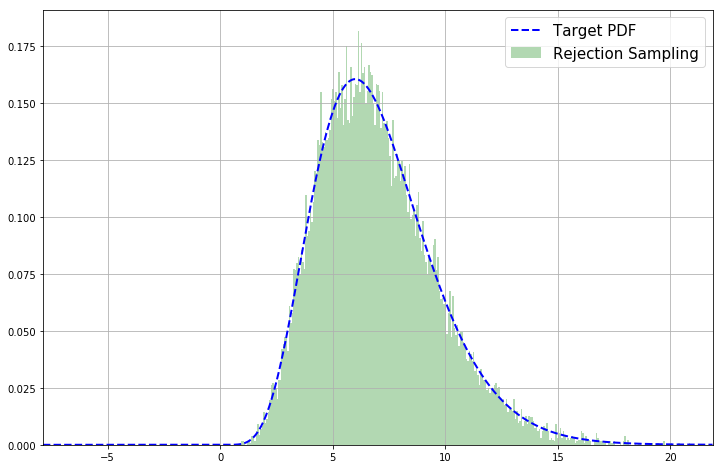

In [43]:
df['Target'].plot(color='blue', style='--', figsize=(12,8), linewidth=2.0)
pd.Series(samples).hist(bins=300, normed=True, color='green', 
                        alpha=0.3, linewidth=0.0)
plt.legend(['Target PDF', 'Rejection Sampling'],fontsize=15)

We see that the normal slightly better approximates the gamma, but still not perfectly.